In [47]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
import soundfile as sf
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [48]:
!pip install soundfile

Defaulting to user installation because normal site-packages is not writeable


In [49]:
# from google.colab import drive
# drive.mount("/content/gdrive")

In [53]:
os.getcwd()

'/home/varun/Desktop/speechReco/data1'

In [51]:
path = '/data1'
os.chdir(os.getcwd() +path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/varun/Desktop/speechReco/data1/data1'

In [54]:
os.getcwd()

'/home/varun/Desktop/speechReco/data1'

In [55]:
os.listdir()

['go',
 'four',
 'happy',
 'nine',
 'bed',
 'house',
 'off',
 'eight',
 'down',
 'no',
 'dog',
 'marvin',
 'on',
 'bird',
 'cat',
 'five',
 'left']

In [56]:
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import soundfile as sf
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [57]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

# Load a wav file
def get_wav_info(wav_file):
    rate , data = wavfile.read(wav_file)
    return rate, data


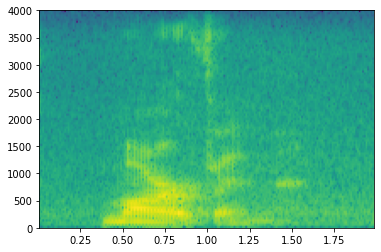

In [58]:
labels = []
file_names = []
samples = []

for direc in os.listdir():
        file = [ f for f in os.listdir(os.getcwd() + '/' + direc ) if f.endswith('.wav')]
        for f in file:
            sample = graph_spectrogram(os.getcwd() + "/" + direc + "/" + f)
            samples.append(sample)
            labels.append(direc)
        if(len(samples)) > 500:
          break
                        

In [59]:
len(labels)

520

In [60]:
len(samples)

520

In [61]:
max_len = 0
for sam in samples:
  if sam.shape[1] > max_len:
    max_len = sam.shape[1]

print(max_len)


198


In [62]:
labels[2]

'go'

In [63]:
new_samples = []
count = 0
for sam in samples:
  a = np.zeros((101,max_len))
  a[:,:sam.shape[1]] = sam
  new_samples.append(a)
  count +=1

print(count)


520


In [64]:
new_samples = np.array(new_samples)
new_samples = new_samples.reshape(520,101,198,1)
print(new_samples.shape)




(520, 101, 198, 1)


In [65]:
max_label = 0
for label in labels:
  if len(label) > max_label:
    max_label = len(label) 



In [66]:
print(max_label)
max_label = 23

6


In [75]:
import numpy as np

#%%
# From Baidu ba-dls-deepspeech - https://github.com/baidu-research/ba-dls-deepspeech
# Character map list

char_map_str = """
<SPACE> 0
a 1
b 2
c 3
d 4
e 5
f 6
g 7
h 8
i 9
j 10
k 11
l 12
m 13
n 14
o 15
p 16
q 17
r 18
s 19
t 20
u 21
v 22
w 23
x 24
y 25
z 26
' 27
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch

index_map[0] = ' '


def get_param(Y):
  labels = np.zeros((520,23))

  for idx,label in enumerate(Y):
    new = []
    for word in label.split():
      for c in word:
        if c not in char_map:
          continue
        elif c == "'":
          continue
        else:
          ch = char_map[c]
          new.append(ch)
#       if(len(new) < max_label):
#         new.append(0)
    while(len(new) < max_label):
      new.append(27)
    labels[idx,:] = np.array(new)

  input_length = np.array([max_label for _ in Y])
  label_length = np.array([max_label for _ in Y])


  return labels , input_length , label_length           

In [76]:
char_map


{'<SPACE>': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 "'": 27}

In [140]:
from keras.layers import *
from keras.layers.wrappers import TimeDistributed
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.utils import plot_model

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length )    
    
        
#%%
class CTC():
    """
    Usage:
        sr_ctc = CTC(enter input_size and output_size)
        sr_ctc.build()
        sr_ctc.m.compile()
        sr_ctc.tm.compile()
    """       
    def __init__(self,
                 input_size=None, 
                 output_size=None,
                 initializer='glorot_uniform'):
        self.input_size = input_size
        self.output_size = output_size
        self.initializer = initializer
        self.m = None
        self.tm = None
                   
    def build(self, 
              conv_filters = 200,
              conv2d_filters = 13,
              conv_size = 5,
              conv2d_strides = 1,
              conv_strides = 4,
              act = 'relu',
              rnn_layers = 2,
              LSTM_units = 128,
              drop_out = 0.8):
           
        i = Input(shape = self.input_size, name = 'input')
        x = Conv2D(conv2d_filters,
                   conv_size,
                   strides = (conv2d_strides, conv2d_strides),
                   padding = "same",
                   name = "conv2d1")(i)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Conv2D(conv2d_filters,
                   conv_size,
                   strides = (conv2d_strides , conv2d_strides),
                   padding = "same",
                   name = "conv2d2")(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Reshape([606,-1])(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d1')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Conv1D(conv_filters, 
                   conv_size, 
                   strides = conv_strides,
                   padding = "same", 
                   name = 'conv1d2')(x)
        x = BatchNormalization()(x)
        x = Activation(act)(x)
        x = Reshape([200,38])(x)
        x = Dense(23 , activation="softmax", name ="dense")(x)
        x = Reshape([23,-1])(x)
        for _ in range(rnn_layers):          
            x = Bidirectional(LSTM(LSTM_units, 
                                   return_sequences = True))(x)
            x = Dropout(drop_out)(x)
            x = BatchNormalization()(x)
        y_pred = TimeDistributed(Dense(self.output_size, 
                                       activation = 'softmax'))(x)        
        # ctc inputs
        labels = Input(name='the_labels', shape=[None,], dtype='int32')
        input_length = Input(name='input_length', shape=[1], dtype='int32')
        label_length = Input(name='label_length', shape=[1], dtype='int32')    
        # Keras doesn't currently support loss funcs with extra parameters
        # so CTC loss is implemented in a lambda layer
        loss_out = Lambda(ctc_lambda_func, 
                          output_shape=(1,), 
                          name='ctc')([y_pred,
                                        labels,
                                        input_length,
                                        label_length])        
        self.tm = Model(inputs = i,
                        outputs = y_pred)
        self.m = Model(inputs = [i, 
                                 labels, 
                                 input_length, 
                                 label_length], 
                        outputs = loss_out)
        return self.m, self.tm


In [141]:
def ctc(y_true, y_pred):
    return y_pred

In [142]:
sr_ctc = CTC((101,198,1), 28)
sr_ctc.build()

(<keras.engine.training.Model at 0x7f7f95e156a0>,
 <keras.engine.training.Model at 0x7f7f95e157f0>)

In [143]:
sr_ctc.m.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 101, 198, 1)  0                                            
__________________________________________________________________________________________________
conv2d1 (Conv2D)                (None, 101, 198, 13) 338         input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_77 (BatchNo (None, 101, 198, 13) 52          conv2d1[0][0]                    
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 101, 198, 13) 0           batch_normalization_77[0][0]     
___________________________________________________________________________________________

In [144]:
sr_ctc.m.compile(loss = ctc, optimizer = 'adam', metrics = ['accuracy'])
sr_ctc.tm.compile(loss = ctc, optimizer = 'adam')


In [145]:
labels_train, input_length, label_length = get_param(Y = labels)
labels_val, input_length_val, label_length_val = get_param(Y = labels)

In [146]:
print(labels_train[0])

[ 7. 15. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27. 27.
 27. 27. 27. 27. 27.]


In [147]:
print(type(labels_train[1]))
print("labels" ,labels_train.shape ," ",input_length.shape ," ", label_length.shape)

<class 'numpy.ndarray'>
labels (520, 23)   (520,)   (520,)


In [149]:
 history = sr_ctc.m.fit([new_samples, 
                            labels_train, 
                            input_length, 
                            label_length], 
                       np.zeros([len(labels_train)]), 
                       batch_size = 10, 
                       epochs = 100, 
                       validation_data = ([new_samples, 
                                           labels_val, 
                                           input_length_val, 
                                           label_length_val],
                                          np.zeros([len(labels_val)])), 
                      #  callbacks = [checkpointer], 
                       verbose = 1
                      #  , shuffle = True
                       )

Train on 520 samples, validate on 520 samples
Epoch 1/100
520/520 [==============================] - 20s 38ms/step - loss: 2.5899 - accuracy: 0.0404 - val_loss: 9.8343 - val_accuracy: 0.1000
Epoch 2/100
520/520 [==============================] - 26s 50ms/step - loss: 2.3391 - accuracy: 0.0558 - val_loss: 8.2928 - val_accuracy: 0.1173
Epoch 3/100
520/520 [==============================] - 26s 50ms/step - loss: 2.2132 - accuracy: 0.0769 - val_loss: 7.7738 - val_accuracy: 0.1423
Epoch 4/100
520/520 [==============================] - 26s 50ms/step - loss: 1.8838 - accuracy: 0.0942 - val_loss: 8.7378 - val_accuracy: 0.1712
Epoch 5/100
520/520 [==============================] - 26s 50ms/step - loss: 1.7839 - accuracy: 0.1462 - val_loss: 5.1463 - val_accuracy: 0.2942
Epoch 6/100
520/520 [==============================] - 26s 50ms/step - loss: 1.7051 - accuracy: 0.1750 - val_loss: 3.7324 - val_accuracy: 0.4212
Epoch 7/100
520/520 [==============================] - 27s 53ms/step - loss: 2.0129 

KeyboardInterrupt: 